In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [23]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [24]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

test_data_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

sample = training_data[0][0]
print(f"Min: {sample.min().item()}, Max: {sample.max().item()}, Mean: {sample.mean().item()}")

sample_normalized = training_data[0][0]
print(f"After Normalize - Min: {sample_normalized.min().item()}, Max: {sample_normalized.max().item()}, Mean: {sample_normalized.mean().item()}")

Min: -1.0, Max: 1.0, Mean: -0.7235394716262817
After Normalize - Min: -1.0, Max: 1.0, Mean: -0.725960373878479


In [25]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_test, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [26]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class CNNModel(nn.Module):
    def __init__(self, num_classes=10,  dropout_rate=0.3):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=7, stride=1),
            nn.Dropout2d(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.classifier(x)
        return x

cnn_model = CNNModel().to(device)
print(cnn_model)

total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using cuda device
CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=1e-3)

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_val, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    train_acc = correct / size
    
    return train_loss, train_acc

In [29]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    test_acc = correct / size
    
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, test_acc

In [30]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn_model, loss_fn, optimizer)
    test(test_dataloader, cnn_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


loss: 2.391093  [   64/60000]
loss: 1.167018  [ 6464/60000]
loss: 0.513295  [12864/60000]
loss: 0.206730  [19264/60000]
loss: 0.165094  [25664/60000]
loss: 0.248502  [32064/60000]
loss: 0.301634  [38464/60000]
loss: 0.148403  [44864/60000]
loss: 0.141677  [51264/60000]
loss: 0.279733  [57664/60000]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.048250 

Epoch 2
-------------------------------
loss: 0.113832  [   64/60000]
loss: 0.243673  [ 6464/60000]
loss: 0.153879  [12864/60000]
loss: 0.198402  [19264/60000]
loss: 0.114473  [25664/60000]
loss: 0.111549  [32064/60000]
loss: 0.364697  [38464/60000]
loss: 0.132525  [44864/60000]
loss: 0.183472  [51264/60000]
loss: 0.071597  [57664/60000]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.030150 

Epoch 3
-------------------------------
loss: 0.060899  [   64/60000]
loss: 0.038888  [ 6464/60000]
loss: 0.063240  [12864/60000]
loss: 0.087927  [19264/60000]
loss: 0.082880  [25664/60000]
loss: 0.053203  [32064/60000]
loss: 0.047895  [38464/60000]
loss: 

In [31]:
torch.save(cnn_model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [32]:
model = CNNModel().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

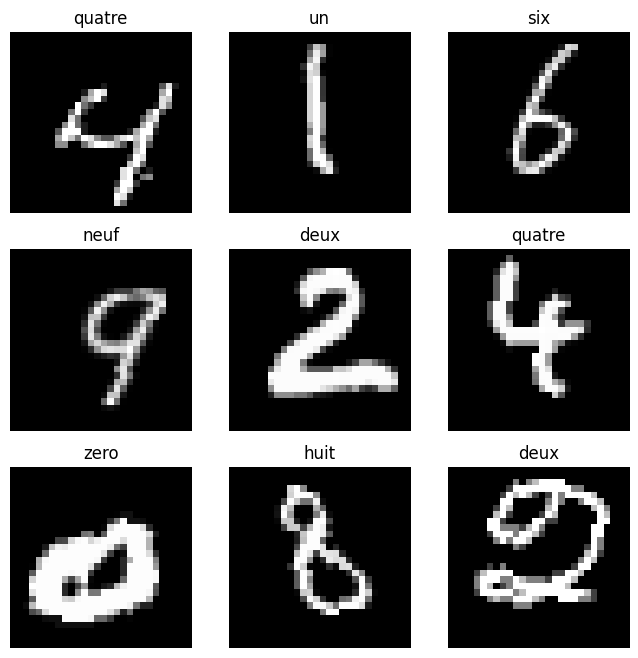

In [33]:
labels_map = {
    0: "zero",
    1: "un",
    2: "deux",
    3: "trois",
    4: "quatre",
    5: "cinq",
    6: "six",
    7: "sept",
    8: "huit",
    9: "neuf",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
import torch.onnx

cnn_model.eval()

dummy_input = torch.randn(1, 1, 28, 28).to(device)

torch.onnx.export(
    cnn_model,
    dummy_input,
    "cnn_model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'}, 
        'output': {0: 'batch_size'}
    }
)

print("Modèle ONNX exporté avec succès !")

Modèle ONNX exporté avec succès !


In [ ]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("cnn_model.onnx")

dummy_input_np = dummy_input.cpu().numpy()
outputs = ort_session.run(['output'], {'input': dummy_input_np})
print("Prédiction ONNX:", np.argmax(outputs[0]))

Prédiction ONNX: 8
